In [ ]:
!pip install networkx
!pip install matplotlib

In [156]:
import networkx as nx
import matplotlib.pyplot as plt

In [157]:
l = 5
lattice = nx.Graph()
lattice.add_nodes_from([(n, m) for n in range(2*l) for m in range(2*l)])
lattice.add_edges_from([((n, m), (n, (m+1)%(2*l))) for n in range(2*l) for m in range(2*l)] +
                         [((n, m), ((n+1)%(2*l) ,m)) for n in range(2*l) for m in range(2*l)])

qubit_coordinates = [(2*n, 2*m+1) for n in range(l) for m in range(l)] + [(2*n+1, 2*m) for n in range(l) for m in range(l)]
vertex_coordinates = {(2*n, 2*m):1 for n in range(l) for m in range(l)}
plaquette_coordinates = [(2*n+1, 2*m+1) for n in range(l) for m in range(l)] 
lattice_qubits = lattice.subgraph(qubit_coordinates)
lattice_vis = lattice.subgraph(qubit_coordinates + list(vertex_coordinates.keys()))
lattice_vertex = lattice.subgraph(list(vertex_coordinates.keys()))
lattice_plaquette = lattice.subgraph(plaquette_coordinates)

num_phys_qubits = len(lattice_qubits.nodes())
print(f"Number of physical qubits needed = {num_phys_qubits}")


Number of physical qubits needed = 50


### Plot a graph of the toric code
Red = Physical qubit, Green = Vertex, Blue = Plaquette

Reminder: Plaquettes are stabilizers for Z-ops and vertices are stabilizers for X-ops

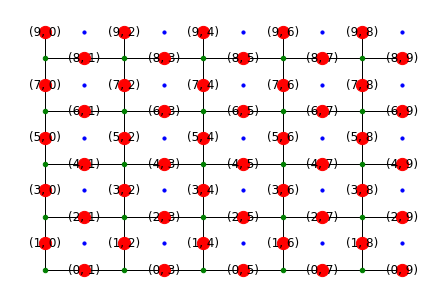

In [175]:
pos = {(x,y):(y,x) for x,y in lattice.nodes()}
# nx.draw(lattice, pos=pos, node_size = 3)
nx.draw(lattice_vis, pos=pos, node_size = 1)
nx.draw(lattice_qubits, with_labels=True, pos=pos, node_color = 'r', node_size = 150)
nx.draw(lattice_vertex, pos=pos, node_color = 'g', node_size = 20)
nx.draw(lattice_plaquette, pos=pos, node_color = 'b', node_size = 10)

Ok lets simulate catching Z errors. These will be caught by the vertex stabilizers

In [172]:
from numpy.random import uniform
prob = 0.1 # Error rate for physical qubit

# Let's store two arrays for each offset grid of qubits
qubits_flipped = {qc: (0 if uniform()>prob else 1) for qc in qubit_coordinates}

# calculate stabilizer eigenvalues
for k in vertex_coordinates.keys():
    vertex_coordinates[k] = 1
    # print(f"vertex = {k}", end=" -- ")
    for offs in [(1,0), (-1,0), (0,1), (0,-1)]:
        qubit = ((k[0]+offs[0])%(2*l), (k[1]+offs[1])%(2*l))
        # print(qubit, end=", ")
        if qubits_flipped[qubit] == 1:
            vertex_coordinates[k] *= -1
    # print()

# print(vertex_coordinates)

Lets check if any of this makes sense

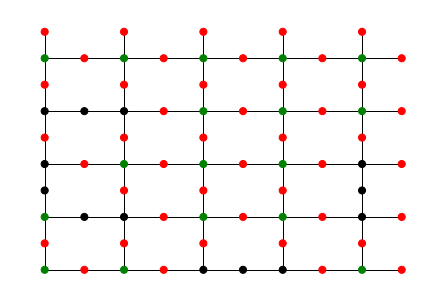

In [173]:
colour_qubits = ['red' if qubits_flipped[q] == 0 else 'black' for q in lattice_qubits]
colour_vertices = ['green' if vertex_coordinates[q] == 1 else 'black' for q in lattice_vertex]
nx.draw(lattice_vis, pos=pos, node_size = 1)
nx.draw(lattice_qubits, pos=pos, node_color=colour_qubits, node_size=50)
nx.draw(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50)

In the above graph, physical qubits that are not flipped are red, and the ones that are flipped are black. For the vertices, green means that the eigenvalue is +1 and black means that the eigenvalue is -1. We can see that the flipped physical qubits form a chain that joins two syndromes (ie vertices with -1 eigenvalue)

To make networkx compute MWPM we must do some cleanup - we must construct the graph of just the syndromes

0

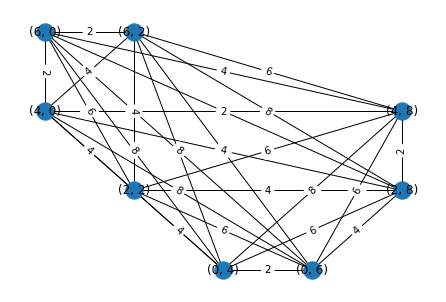

In [189]:
def weight(p1, p2, l):
    r1, c1 = p1
    r2, c2 = p2
    return min(abs(r1-r2), 2*l-abs(r1-r2)) + min(abs(c1-c2), 2*l-abs(c1-c2))

syndromes = [q for q in lattice_vertex if vertex_coordinates[q] == -1]
syndrome_edges = [(p1, p2, {'weight': weight(p1,p2, l)}) for i,p1 in enumerate(syndromes) for j,p2 in enumerate(syndromes) if i>j]
syndrome_G = nx.Graph()
syndrome_G.add_nodes_from(syndromes)
syndrome_G.add_edges_from(syndrome_edges)
nx.draw(syndrome_G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(syndrome_G, pos=pos, edge_labels=nx.get_edge_attributes(syndrome_G,'weight'))
0

In [182]:
nx.min_weight_matching(syndrome_G, weight='weight')

{((0, 6), (0, 4)), ((2, 8), (2, 2)), ((4, 8), (4, 0)), ((6, 2), (6, 0))}